In [35]:
import regex as re
import os
import pickle
import sys
import math
import time
from collections import defaultdict
import matplotlib.pyplot as plt

In [13]:
folder_path = './Selma/'

In [14]:
def read_file(filename):
    with open('./Selma/'+filename) as f:
        return f.read()

In [15]:
def get_words(filename, reg=re.compile('\p{L}+')):
    return re.findall(reg, read_file(filename).lower())

In [16]:
# Returns scanner objects that can be used to extract position information
def tokenize(text, regex=re.compile('\p{L}+')):
    return re.finditer(regex, text)

In [17]:
# Constructs a dictionary with words as keys and character offset from beginning of document as values.
def text_to_idx(tokens):
    ddict = defaultdict(list)
    for token in tokens:
        ddict[token.group()].append(token.start())
    return ddict

In [18]:
text = read_file('marbacka.txt').lower()
tokens = tokenize(text)
idx = text_to_idx(tokens)

In [19]:
pickle.dump(idx, open('marbacka_idx', 'wb'))
idx = pickle.load(open('marbacka_idx', 'rb'))

In [20]:
def get_files(dir, suffix):
    """
    Returns all the files in a folder ending with suffix
    :param dir:
    :param suffix:
    :return: the list of file names
    """
    files = []
    for file in os.listdir(dir):
        if file.endswith(suffix):
            files.append(file)
    return files

In [21]:
all_files = get_files(folder_path, '.txt')

In [22]:
master_index = defaultdict(dict)
for file in all_files:
    text = read_file(file).lower()
    tokens = tokenize(text)
    idx = text_to_idx(tokens)
    
    # Insert into master dictionary where the word is the key and the value is a dictionary with the
    # file as the key and value is the indexes of occurences
    for key, value in idx.items():
        master_index[key][file] = value

In [23]:
pickle.dump(master_index, open('master_index', 'wb'))
master_index = pickle.load(open('master_index', 'rb'))

In [24]:
master_index['samlar']

{'osynliga.txt': [399121],
 'troll.txt': [641880, 654233],
 'nils.txt': [51805, 118943],
 'gosta.txt': [313784, 409998, 538165]}

In [25]:
def concordance(word, master_index, corpus_files, window_size):
    occurences = []
    for file in master_index[word]:
        if file in corpus_files:
            text = read_file(file).lower()
            for occurence in master_index[word][file]:
                center = occurence + len(word) // 2
                shift = window_size // 2
                occurences.append(text[center - shift: center + shift])
            
    return occurences

In [26]:
concordance('samlar', master_index, get_files(folder_path, '.txt'), 30)

[' kärran och samlar just ihop t',
 'läkare, som samlar in markens ',
 'h medan hon samlar och handlar',
 ' i all hast samlar ihop så myc',
 'mma, och nu samlar de sig för ',
 'a borg, och samlar ihop ett li',
 'a.\n\nmen hon samlar upp allt de',
 'et.\n\ndärmed samlar han korten ']

In [27]:
total_words = {file: len(get_words(file))
               for file in get_files(folder_path, '.txt')}

In [28]:
total_words['marbacka.txt']

67334

In [29]:
def tf_idf(file, corpus_files, word, total_words, master_index):
    tf = len(master_index[word].get(file, [])) / total_words[file]
    
    file_occurences = sum(1 for file in corpus_files if file in master_index[word])
    idf = math.log10(len(corpus_files) / file_occurences)
    
    return tf * idf

In [30]:
all_words = []
all_files = get_files(folder_path, '.txt')
for file in all_files:
    all_words += get_words(file)
all_words = set(all_words)

tfidf = defaultdict(dict)
for file in all_files:
    for word in all_words:
        tfidf[file][word] = tf_idf(file, all_files, word, total_words, master_index)

In [31]:
tfidf['kejsaren.txt']['nils']

8.08284798629935e-06

In [32]:
def cosine_simularity(file1, file2, all_words, tfidf):
    dot_product = sum(tfidf[file1].get(word, 0) * tfidf[file2].get(word, 0) for word in all_words)
    
    norm_f1 = math.sqrt(sum(tfidf[file1].get(word, 0) ** 2 for word in all_words))
    norm_f2 = math.sqrt(sum(tfidf[file2].get(word, 0) ** 2 for word in all_words))
    return dot_product / (norm_f1 * norm_f2)

def similarity_matrix(files, all_words, tfidf):
    sim_mat = [[0 for file in files] for file in files]
    for i, file1 in enumerate(files):
        for j, file2 in enumerate(files):
            sim_mat[i][j] = cosine_simularity(file1, file2, all_words, tfidf)
            
    return sim_mat

In [33]:
sim_mat = similarity_matrix(get_files(folder_path, '.txt'), all_words, tfidf)

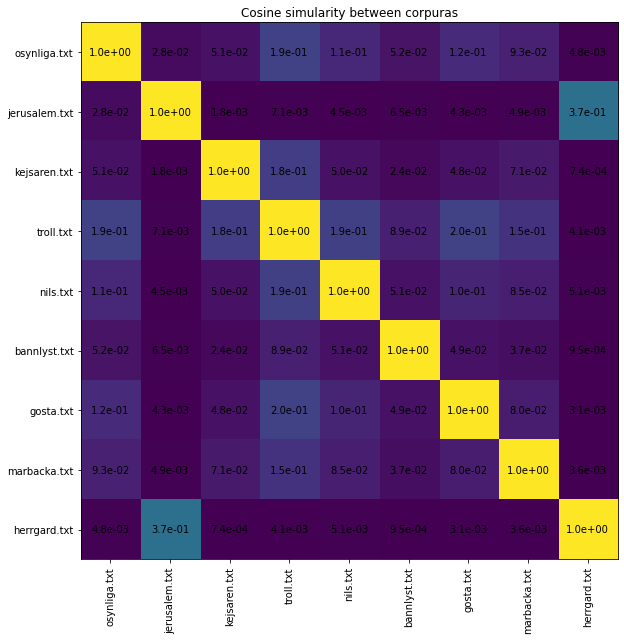

In [73]:
fig, ax = plt.subplots(figsize=(16, 9))

ax.imshow(sim_mat)

ax.set_xticks(list(range(9)))
ax.set_xticklabels(all_files, rotation=90)

ax.set_yticks(list(range(9)))
ax.set_yticklabels(all_files)

for i, row in enumerate(sim_mat):
    for j, elem in enumerate(row):
        text = ax.text(j, i, '{:.1e}'.format(elem),
                       ha='center', va='center', color='k')

ax.set_title('Cosine simularity between corpuras')
fig.tight_layout()
plt.show()